## Prompt-to-Prompt with Stable Diffusion

In [1]:
from typing import Optional, Union, Tuple, List, Callable, Dict
import torch, sys

import torch.nn.functional as nnf
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm, trange
from einops import rearrange
from torchvision.utils import make_grid
import abc
import ldm.ptp_utils as ptp_utils
sys.path.append('..')
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler


/home/gpu/anaconda3/envs/ldm2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


For loading the Stable Diffusion using Diffusers, follow the instuctions https://huggingface.co/blog/stable_diffusion and update ```MY_TOKEN``` with your token.
Set ```LOW_RESOURCE``` to ```True``` for running on 12GB GPU.

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
LOW_RESOURCE = False 
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 10
MAX_NUM_WORDS = 77


def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model.cuda()
    model.eval()
    return model

config = OmegaConf.load("configs/stable-diffusion/v1-inference.yaml")  # TODO: Optionally download from same location as ckpt and chnage this logic
model = load_model_from_config(config, "models/sd/v1-5.ckpt")  # TODO: check path

model = model.to(device)
sampler = DDIMSampler(model)

tokenizer = model.cond_stage_model.tokenizer

Loading model from /data/roy/PrefixDiffusion3/models/sd/v1-5.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at /home/gpu/.cache/clip_vit_large_patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.0.layer_norm2.bias', 'vision_model.encoder.layers.10.mlp.fc1.weight', 'vision_model.encoder.layers.12.mlp.fc1.bias', 'vision_model.encoder.layers.22.self_attn.out_proj.bias', 'vision_model.encoder.layers.2.self_attn.q_proj.weight', 'vision_model.encoder.layers.4.layer_norm2.weight', 'vision_model.encoder.layers.15.layer_norm1.bias', 'vision_model.encoder.layers.8.mlp.fc1.bias', 'vision_model.encoder.layers.14.layer_norm1.weight', 'vision_model.encoder.layers.3.mlp.fc1.weight', 'vision_model.encoder.layers.0.mlp.fc2.weight', 'vision_model.encoder.layers.23.mlp.fc2.weight', 'vision_model.encoder.layers.10.self_attn.q_proj.weight', 'vision_model.encoder.layers.11.self_attn.out_proj.bias', 'vision_model.encoder.layers.12.mlp.fc2.bias', 'vision_model.encoder.layers.18.layer_norm2.bias', 'vision_model.encoder.layers.18.layer_norm1.bias',

_______________adapter_train_summary__________________
Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
prefix_tuning1           prefix_tuning         4,608       0.004       1       1
--------------------------------------------------------------------------------
Full model                               123,060,480     100.000               0
CLIPTextModel(
  (shared_parameters): ModuleDict()
  (text_model): CLIPTextTransformer(
    (invertible_adapters): ModuleDict()
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0): CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(
              in_features=768, out_features=768, bias=True
              (loras): ModuleDict()
            )
          

## Prompt-to-Prompt Attnetion Controllers
Our main logic is implemented in the `forward` call in an `AttentionControl` object.
The forward is called in each attention layer of the diffusion model and it can modify the input attnetion weights `attn`.

`is_cross`, `place_in_unet in ("down", "mid", "up")`, `AttentionControl.cur_step` help us track the exact attention layer and timestamp during the diffusion iference.


In [3]:

class AttentionControl(abc.ABC):
    
    def step_callback(self, x_t):
        return x_t
    
    def between_steps(self):
        return
    
    @property
    def num_uncond_att_layers(self):
        return self.num_att_layers if LOW_RESOURCE else 0
    
    @abc.abstractmethod
    def forward (self, attn, is_cross: bool, place_in_unet: str):
        raise NotImplementedError

    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        if self.cur_att_layer >= self.num_uncond_att_layers:
            if LOW_RESOURCE:
                attn = self.forward(attn, is_cross, place_in_unet)
            else:
                h = attn.shape[0]
                attn[h // 2:] = self.forward(attn[h // 2:], is_cross, place_in_unet)
        self.cur_att_layer += 1
        if self.cur_att_layer == self.num_att_layers + self.num_uncond_att_layers:
            self.cur_att_layer = 0
            self.cur_step += 1
            self.between_steps()
        return attn
    
    def reset(self):
        self.cur_step = 0
        self.cur_att_layer = 0

    def __init__(self):
        self.cur_step = 0
        self.num_att_layers = -1
        self.cur_att_layer = 0


class AttentionStore(AttentionControl):

    @staticmethod
    def get_empty_store():
        return {"down_cross": [], "mid_cross": [], "up_cross": [],
                "down_self": [],  "mid_self": [],  "up_self": []}

    def forward(self, attn, is_cross: bool, place_in_unet: str):
        key = f"{place_in_unet}_{'cross' if is_cross else 'self'}"
        if attn.shape[1] <= 32 ** 2:  # avoid memory overhead
            self.step_store[key].append(attn)
        return attn

    def between_steps(self):
        if len(self.attention_store) == 0:
            self.attention_store = self.step_store
        else:
            for key in self.attention_store:
                for i in range(len(self.attention_store[key])):
                    self.attention_store[key][i] += self.step_store[key][i]
        self.step_store = self.get_empty_store()

    def get_average_attention(self):
        average_attention = {key: [item / self.cur_step for item in self.attention_store[key]] for key in self.attention_store}
        return average_attention


    def reset(self):
        super(AttentionStore, self).reset()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

    def __init__(self):
        super(AttentionStore, self).__init__()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

In [4]:
from PIL import Image

def aggregate_attention(attention_store: AttentionStore, res: int, from_where: List[str], is_cross: bool, select: int):
    out = []
    attention_maps = attention_store.get_average_attention()
    num_pixels = res ** 2
    for location in from_where:
        for item in attention_maps[f"{location}_{'cross' if is_cross else 'self'}"]:
            if item.shape[1] == num_pixels:
                cross_maps = item.reshape(1, -1, res, res, item.shape[-1])[select]
                out.append(cross_maps)
    out = torch.cat(out, dim=0)
    out = out.sum(0) / out.shape[0]
    return out.cpu()


def show_cross_attention(attention_store: AttentionStore, res: int, from_where: List[str], select: int = 0):
    tokens = tokenizer.encode(prompts)
    print("lenth of tokens:  "+str(len(tokens)))
    decoder = tokenizer.decode
    attention_maps = aggregate_attention(attention_store, res, from_where, True, select)
    images = []
    images_each = []
    #result img
    # print(image2.shape) #（1，512，512，3）
    # image2= np.squeeze(image2, axis=0)
    # image2 = np.array(Image.fromarray(image2).resize((256, 256)))
    
    for i in range(len(tokens)):
        image = attention_maps[:, :, i]
        attn_map = image
        image = 255 * image / image.max()

        image = image.unsqueeze(-1).expand(*image.shape, 3)

        image = image.numpy().astype(np.uint8) # 16 16 3
        
        #save each 16x16 img
        save_path=f'visualization_results/attention_map_{decoder(int(tokens[i]))}'
        vis_attention_matrix(attn_map, index=i, cmap="coolwarm", save_path=save_path)
        images_each.append(image) #list[array]
        
        #show each 256x256 img
        image = np.array(Image.fromarray(image).resize((256, 256)))
        image = ptp_utils.text_under_image(image, decoder(int(tokens[i])))
        images.append(image)
    ptp_utils.view_images(np.stack(images, axis=0))
    return images_each
    

def show_self_attention_comp(attention_store: AttentionStore, res: int, from_where: List[str],
                        max_com=10, select: int = 0):
    attention_maps = aggregate_attention(attention_store, res, from_where, False, select).numpy().reshape((res ** 2, res ** 2))
    u, s, vh = np.linalg.svd(attention_maps - np.mean(attention_maps, axis=1, keepdims=True))
    images = []
    for i in range(max_com):
        image = vh[i].reshape(res, res)
        image = image - image.min()
        image = 255 * image / image.max()
        image = np.repeat(np.expand_dims(image, axis=2), 3, axis=2).astype(np.uint8)
        image = Image.fromarray(image).resize((256, 256))
        image = np.array(image)
        images.append(image)
    ptp_utils.view_images(np.concatenate(images, axis=1))
    
from matplotlib import pyplot as plt
import seaborn as sns
    
def vis_attention_matrix(attention_map, index=0, cmap="YlGnBu_r", save_path=None):
    
    """
    :param attention_map: 
    :param index: 
    :param cmap:
    :save_path: 
    :return:
    """
    ### personalized setting:
    if index==1:
        vmax=0.18
    elif index==3:
        vmax=0.018
    elif index==6:
        vmax=0.18
    else:
        vmax=attention_map.max()    
    ###
    
    plt.figure(dpi=120)
    sns.heatmap(
        attention_map,
        #vmin=attention_map.min(), vmax=attention_map.max(),
        vmin=attention_map.min(), vmax=vmax,
        cmap=cmap,
        #annot=False,
        square=True)
    plt.savefig(save_path)
    # print(f'[attention_matrix_{index}.png] is generated')
    return 

In [5]:
def run_and_display(prompts, controller, sampler=sampler, latent=None, iter_seed=None):
    
    images = ptp_utils.text2image_ldm_stable(model, prompts, controller, sampler=sampler, num_inference_steps=50, guidance_scale=10, iter_seed=iter_seed)
    ptp_utils.view_images(images)
 

## Cross-Attention Visualization
First let's generate an image and visualize the cross-attention maps for each word in the prompt.
Notice, we normalize each map to 0-1.

Overwriting existing adapter 'prefix_tuning1'.


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.47it/s]


out len+  1


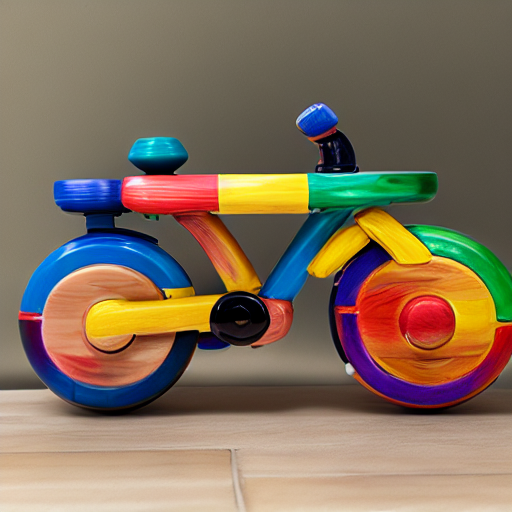

In [8]:


#####
embedding_path="logs/colorful_teapot/checkpoints/adapter_gs-999"
model.cond_stage_model.adapter_load(embedding_path)
prompts = 'colorful_teapot bicycle'
iter_seed=857

controller = AttentionStore()

run_and_display(prompts, controller, sampler=sampler, iter_seed=iter_seed)
# attention_list=show_cross_attention(controller, res=16, from_where=("up", "down"))

Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler:   0%|          | 0/50 [00:00<?, ?it/s]

DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.46it/s]


out len+  1


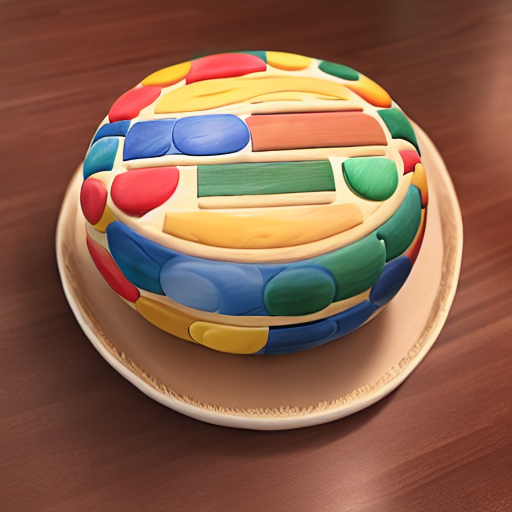

In [10]:
prompts = 'colorful_teapot cake'
iter_seed=545
controller = AttentionStore()

run_and_display(prompts, controller, sampler=sampler, iter_seed=iter_seed)
#attention_list=show_cross_attention(controller, res=16, from_where=("up", "down"))

Overwriting existing adapter 'prefix_tuning1'.


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.47it/s]


out len+  1


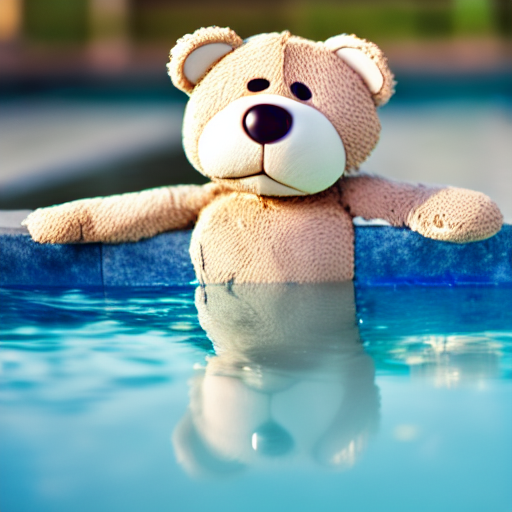

In [6]:
#####
embedding_path="logs/teddybear/checkpoints/adapter_gs-999"
model.cond_stage_model.adapter_load(embedding_path)
prompts = 'teddybear on swimming pool'
iter_seed=231

controller = AttentionStore()

run_and_display(prompts, controller, sampler=sampler, iter_seed=iter_seed)
# attention_list=show_cross_attention(controller, res=16, from_where=("up", "down"))

Overwriting existing adapter 'prefix_tuning1'.


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.49it/s]


out len+  1


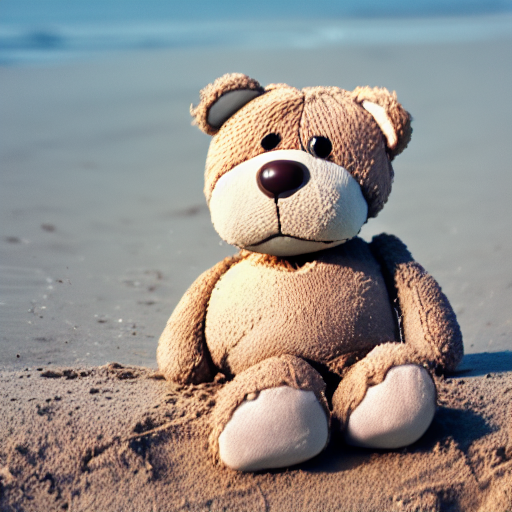

In [7]:
#####
embedding_path="logs/teddybear/checkpoints/adapter_gs-999"
model.cond_stage_model.adapter_load(embedding_path)
prompts = 'teddybear on the beach'
iter_seed=78

controller = AttentionStore()

run_and_display(prompts, controller, sampler=sampler, iter_seed=iter_seed)
# attention_list=show_cross_attention(controller, res=16, from_where=("up", "down"))